In [7]:
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import k_clique_communities

import matplotlib.pyplot as plt

from community import community_louvain

import markov_clustering as mc

import numpy as np
import scipy as sp
import pandas as pd

from protclus import MCODE
from protclus import COACH
from protclus import IPCA
from protclus import DPCLUS

import csv


yeast_file = "yeast_network.txt"

## Helper Functions

In [8]:
def get_cluster(clusters):
    predicted_complexes = []

    for cluster in clusters:
        ls = set()
        for node in cluster:
            ls.add(node)
        predicted_complexes.append(ls)

    predicted_complexes.sort(key = len)
    predicted_complexes.reverse()
    
    return predicted_complexes
    

In [9]:
def get_clusterfile(cluster_file):

    predicted_complexes = []

    counter = 0
    with open(cluster_file) as f:
        for line in f:
            ls = []
            cluster = line.split()
            for node in cluster:
                counter += 1
                ls.append(node)
            predicted_complexes.append(ls)


    predicted_complexes.sort(key = len)
    predicted_complexes.reverse()
    return predicted_complexes

In [10]:
def cluster_filter(clusters, min_length):
    filtered_clusters = []
    for cluster in clusters:
        if len(cluster) >= min_length:
            filtered_clusters.append(cluster)
            
    return filtered_clusters

In [11]:
def get_cluster_by_indices(clusters, G):
    node_arr = list(G.nodes)
    predicted_complexes = []

    for cluster in clusters:
        ls = set()
        for i in cluster:
            ls.add(node_arr[i])
        if len(ls) > 1:
            predicted_complexes.append(ls)

    predicted_complexes.sort(key = len)
    predicted_complexes.reverse()
    
    return predicted_complexes

In [12]:
def gs_list(test_file):
    reference_complexes = []

    with open(test_file) as f:
        for line in f:
            reference_complexes.append(line.split())


    reference_complexes.sort(key = len)
    reference_complexes.reverse()
    
    return reference_complexes

## Metric Evaluation Functions

In [13]:
# Calculates Recall
def Recall(predicted_clusters, reference_clusters, t):

    correct = 0
    counter = 0

    for reference in reference_clusters:
        counter += 1
        for cluster in predicted_clusters:
            intersection = len(set(cluster) & set(reference))
            if intersection/(len(set(cluster))+len(set(reference))) > t:
                correct += 1
                break
    
    return correct/counter
    

In [14]:
# Calculates Precision
def Precision(predicted_clusters, reference_clusters, t):

    correct = 0
    counter = 0

    for cluster in predicted_clusters:
        counter += 1
        for reference in reference_clusters:
            intersection = len(set(cluster) & set(reference))
            if intersection/(len(set(cluster))+len(set(reference))) > t:
                correct += 1
                break



    return correct/counter

In [15]:
# Calculates F_measure
def F_measure(recall, precision):
    
    if precision + recall == 0:
        return 0
    return 2*precision*recall/(precision + recall)

In [16]:
# Calculates Positive Predicitive Value
def PPV(predicted_clusters, reference_clusters):
    
    sum = 0
    counter = 0

    for cluster in predicted_clusters:
        max = 0
        for reference in reference_clusters:
            intersection = len(set(cluster) & set(reference))
            counter += intersection
            if intersection > max:
                max = intersection
        sum += max




    return sum/counter

In [17]:
# Calculates Sensitivity
def SN(predicted_clusters, reference_clusters):
    
    sum = 0
    counter = 0

    for cluster in reference_clusters:
        max = 0
        counter += len(cluster)
        for reference in predicted_clusters:
            intersection = len(set(cluster) & set(reference))
            if intersection > max:
                max = intersection
        sum += max




    return sum/counter

In [18]:
# Calculates Accuracy
def ACC(PPV, SN):
    
    return (PPV * SN)**0.5

In [19]:
# Calculates Separation score
def SEP(predicted_clusters, reference_clusters):
    sum1 = 0
    counter1 = 0

    for cluster in predicted_clusters:
        counter1 += 1
        for reference in reference_clusters:
            intersection = len(set(cluster) & set(reference))
            sum1 += intersection**2/(len(set(cluster))*len(set(reference)))
            
            
    sum2 = 0
    counter2 = 0

    for cluster in reference_clusters:
        counter2 += 1
        for reference in predicted_clusters:
            intersection = len(set(cluster) & set(reference))
            sum2 += intersection**2/(len(set(cluster))*len(set(reference)))
            
    return (sum1*sum2/(counter1*counter2))**0.5
        

In [20]:
# Return the array of the 7 metric values
def get_results(predicted_clusters, reference_clusters):
    
    recall = Recall(predicted_clusters, reference_clusters, 0.3)
    precision = Precision(predicted_clusters, reference_clusters, 0.3)
    f_measure = F_measure(recall, precision)
    ppv = PPV(predicted_clusters, reference_clusters)
    sn = SN(predicted_clusters, reference_clusters)
    accuracy = ACC(ppv, sn)
    sep = SEP(predicted_clusters, reference_clusters)
    
    return [recall, precision, f_measure, ppv, sn, accuracy, sep, len(predicted_clusters)]

In [21]:
def get_cluster_len(predicted_clusters):
    
    ls = []
    
    for cluster in predicted_clusters:
        ls.append(len(cluster))
        
    
    return ls

In [22]:
# Load the processed network

G0 = nx.read_edgelist(yeast_file,comments="#",nodetype=str)

## MCL

In [23]:
matrix = nx.adjacency_matrix(G0).todense()
result = mc.run_mcl(matrix)
clusters = mc.get_clusters(result)


In [24]:
mcl_predicted_clusters = get_cluster_by_indices(clusters, G0)

## MCODE

In [ ]:
c = MCODE(yeast_file)
c.cluster()

In [26]:
mcode_predicted_clusters = get_cluster(c.clusters)

## DPCLUS

In [27]:
c = DPCLUS(yeast_file)
c.cluster()

In [28]:
dpclus_predicted_clusters = get_cluster(c.clusters)

## CoAch

In [ ]:
c = COACH(yeast_file)
c.cluster()

In [30]:
coach_predicted_clusters = get_cluster(c.clusters)

## EWCA

In [31]:
ewca_predicted_clusters = get_clusterfile("EWCA_results.txt")

# Results

## CYC2008 Gold Standard

In [32]:
# Load the gold standard
reference_clusters = gs_list('CYC2008.txt')

In [33]:
mcl_results = get_results(mcl_predicted_clusters, reference_clusters)
mcode_results = get_results(mcode_predicted_clusters, reference_clusters)
dpclus_results = get_results(dpclus_predicted_clusters, reference_clusters)
coach_results = get_results(coach_predicted_clusters, reference_clusters)
ewca_results = get_results(ewca_predicted_clusters, reference_clusters)

In [34]:
model_results = [mcl_results, mcode_results, dpclus_results, coach_results, ewca_results]


recall_arr = [result[0] for result in model_results]
precision_arr = [result[1] for result in model_results]
f_measure_arr = [result[2] for result in model_results]
ppv_arr = [result[3] for result in model_results]
sn_arr = [result[4] for result in model_results]
accuracy_arr = [result[5] for result in model_results]
sep_arr = [result[6] for result in model_results]
size_arr = [result[7] for result in model_results]

### Recall, Precision and F-measure

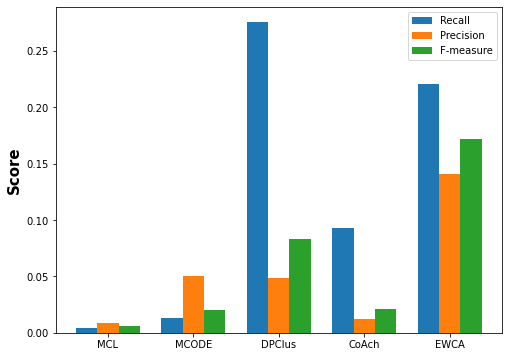

In [35]:
barWidth = 0.25
fig = plt.subplots(figsize =(8, 6)) 
 
# Set position of bar on X axis 
br1 = np.arange(len(recall_arr)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
 
# Make the plot
plt.bar(br1, recall_arr,  width = barWidth, 
         label ='Recall') 
plt.bar(br2, precision_arr,  width = barWidth, 
         label ='Precision') 
plt.bar(br3, f_measure_arr, width = barWidth, 
        label ='F-measure') 
 
# Adding Xticks 
plt.ylabel('Score', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(recall_arr))], 
        ['MCL', 'MCODE', 'DPClus', 'CoAch', 'EWCA'])
 
plt.legend()
plt.show() 

### Positive Predicitive Value

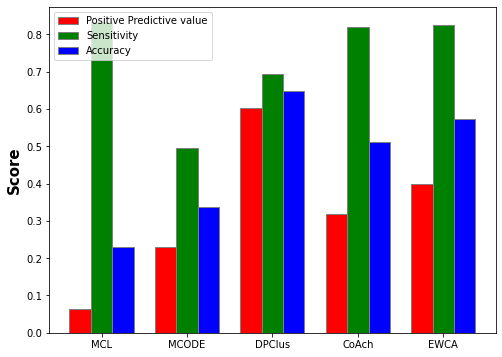

In [36]:
barWidth = 0.25
fig = plt.subplots(figsize =(8, 6)) 
 
# Set position of bar on X axis 
br1 = np.arange(len(recall_arr)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
 
# Make the plot
plt.bar(br1, ppv_arr, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Positive Predictive value') 
plt.bar(br2, sn_arr, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Sensitivity') 
plt.bar(br3, accuracy_arr, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Accuracy') 
 
# Adding Xticks 
plt.ylabel('Score', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(recall_arr))], 
        ['MCL', 'MCODE', 'DPClus', 'CoAch', 'EWCA'])
 
plt.legend()
plt.show() 

### Separation and number of clusters

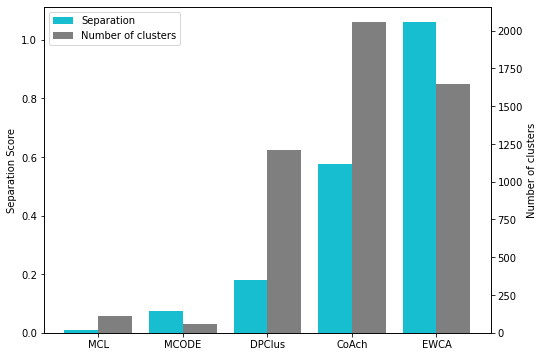

In [37]:
fig, ax1 = plt.subplots(figsize =(8, 6))
ax2 = ax1.twinx()

model_names = ["MCL", "MCODE", "DPClus", "CoAch", "EWCA"]


X_axis = np.arange(len(model_names))

ax1.set_xticks(X_axis, model_names) 

l1 = ax1.bar(X_axis-0.2, sep_arr,
        width = 0.4, color = '#17becf', label = 'Separation')
ax1.set_ylabel("Separation Score")

l2 = ax2.bar(X_axis+0.2, size_arr,
        width = 0.4, color = '#7f7f7f', label = 'Number of clusters')
ax2.set_ylabel("Number of clusters")


plt.legend([l1,l2], ["Separation", "Number of clusters"])
plt.show()

In [38]:
mcl_distr = get_cluster_len(mcl_predicted_clusters)
mcode_distr = get_cluster_len(mcode_predicted_clusters)
dpclus_distr = get_cluster_len(dpclus_predicted_clusters)
coach_distr = get_cluster_len(coach_predicted_clusters)
ewca_distr = get_cluster_len(ewca_predicted_clusters)

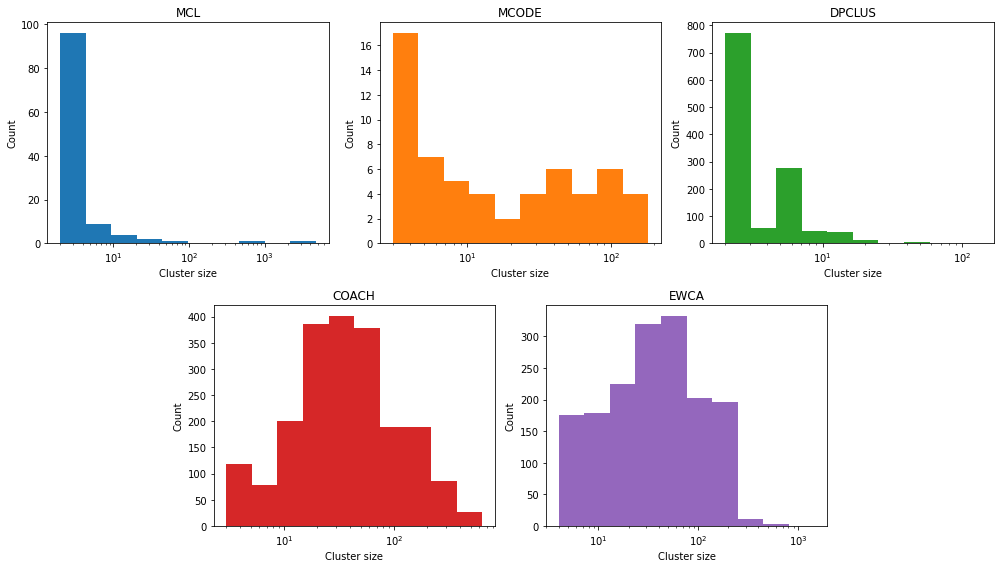

In [39]:
plt.figure(figsize = (14,8))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)



counts, bins = np.histogram(mcl_distr, bins = 10)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax1.hist(mcl_distr, bins=logbins)
ax1.set_title('MCL')
ax1.set_xscale('log')
ax1.set_xlabel('Cluster size')
ax1.set_ylabel('Count')

counts, bins = np.histogram(mcode_distr)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax2.hist(mcode_distr, bins=logbins,facecolor ='#ff7f0e')
ax2.set_title('MCODE')
ax2.set_xscale('log')
ax2.set_xlabel('Cluster size')
ax2.set_ylabel('Count')

counts, bins = np.histogram(dpclus_distr)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax3.hist(dpclus_distr, bins=logbins,facecolor ='#2ca02c')
ax3.set_title('DPCLUS')
ax3.set_xscale('log')
ax3.set_xlabel('Cluster size')
ax3.set_ylabel('Count')

counts, bins = np.histogram(coach_distr)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax4.hist(coach_distr, bins=logbins,facecolor ='#d62728')
ax4.set_title('COACH')
ax4.set_xscale('log')
ax4.set_xlabel('Cluster size')
ax4.set_ylabel('Count')

counts, bins = np.histogram(ewca_distr)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax5.hist(ewca_distr, bins=logbins,facecolor ='#9467bd')
ax5.set_title('EWCA')
ax5.set_xscale('log')
ax5.set_xlabel('Cluster size')
ax5.set_ylabel('Count')

plt.tight_layout()
plt.show()

### We filter out clusters that have size less than 5.

In [40]:
mcl_predicted_clusters_filter = cluster_filter(mcl_predicted_clusters, 5)
mcode_predicted_clusters_filter = cluster_filter(mcode_predicted_clusters, 5)
dpclus_predicted_clusters_filter = cluster_filter(dpclus_predicted_clusters, 5)
coach_predicted_clusters_filter = cluster_filter(coach_predicted_clusters, 5)
ewca_predicted_clusters_filter = cluster_filter(ewca_predicted_clusters, 5)

In [41]:
mcl_results = get_results(mcl_predicted_clusters_filter, reference_clusters)
mcode_results = get_results(mcode_predicted_clusters_filter, reference_clusters)
dpclus_results = get_results(dpclus_predicted_clusters_filter, reference_clusters)
coach_results = get_results(coach_predicted_clusters_filter, reference_clusters)
ewca_results = get_results(ewca_predicted_clusters_filter, reference_clusters)

In [42]:
model_results = [mcl_results, mcode_results, dpclus_results, coach_results, ewca_results]


recall_arr = [result[0] for result in model_results]
precision_arr = [result[1] for result in model_results]
f_measure_arr = [result[2] for result in model_results]
ppv_arr = [result[3] for result in model_results]
sn_arr = [result[4] for result in model_results]
accuracy_arr = [result[5] for result in model_results]
sep_arr = [result[6] for result in model_results]
size_arr = [result[7] for result in model_results]

### Recall, Precision and F-measure on filtered clusters

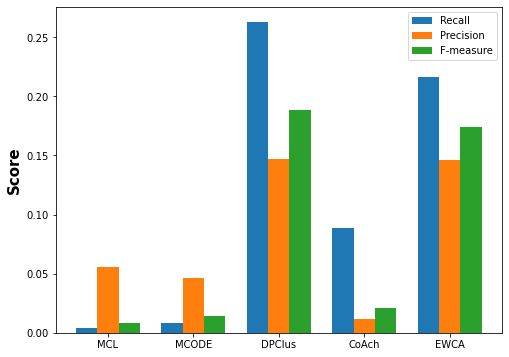

In [43]:
barWidth = 0.25
fig = plt.subplots(figsize =(8, 6)) 
 
# Set position of bar on X axis 
br1 = np.arange(len(recall_arr)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
 
# Make the plot
plt.bar(br1, recall_arr,  width = barWidth,  label ='Recall') 
plt.bar(br2, precision_arr, width = barWidth,  label ='Precision') 
plt.bar(br3, f_measure_arr, width = barWidth,  label ='F-measure') 
 
# Adding Xticks 
plt.ylabel('Score', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(recall_arr))], 
        ['MCL', 'MCODE', 'DPClus', 'CoAch', 'EWCA'])
 
plt.legend()
plt.show() 

### Positive Preditive Value, Sensitivity and Accuracy on filtered clusters

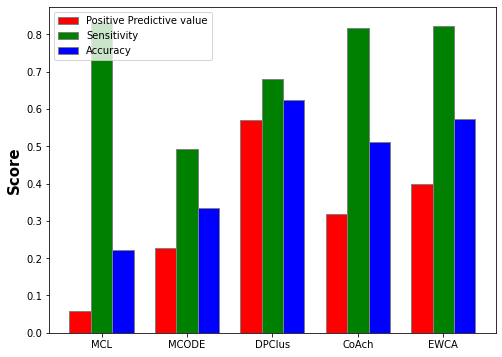

In [44]:
barWidth = 0.25
fig = plt.subplots(figsize =(8, 6)) 
 
# Set position of bar on X axis 
br1 = np.arange(len(recall_arr)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
 
# Make the plot
plt.bar(br1, ppv_arr, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Positive Predictive value') 
plt.bar(br2, sn_arr, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Sensitivity') 
plt.bar(br3, accuracy_arr, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Accuracy') 
 
# Adding Xticks 
plt.ylabel('Score', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(recall_arr))], 
        ['MCL', 'MCODE', 'DPClus', 'CoAch', 'EWCA'])
 
plt.legend()
plt.show() 

### Separation and number of clusters on the filtered clusters

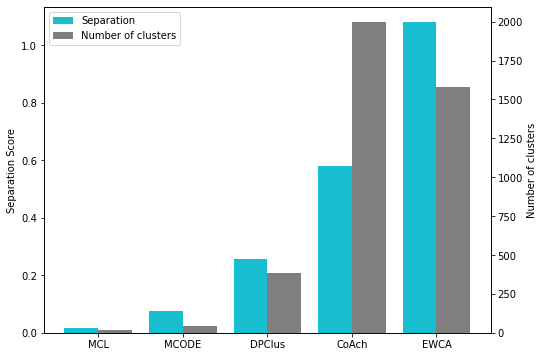

In [45]:
fig, ax1 = plt.subplots(figsize =(8, 6))
ax2 = ax1.twinx()

model_names = ["MCL", "MCODE", "DPClus", "CoAch", "EWCA"]


X_axis = np.arange(len(model_names))

ax1.set_xticks(X_axis, model_names) 

l1 = ax1.bar(X_axis-0.2, sep_arr,
        width = 0.4, color = '#17becf', label = 'Separation')
ax1.set_ylabel("Separation Score")

l2 = ax2.bar(X_axis+0.2, size_arr,
        width = 0.4, color = '#7f7f7f', label = 'Number of clusters')
ax2.set_ylabel("Number of clusters")


plt.legend([l1,l2], ["Separation", "Number of clusters"])
plt.show()

In [46]:
mcl_distr_filter = get_cluster_len(mcl_predicted_clusters_filter)
mcode_distr_filter = get_cluster_len(mcode_predicted_clusters_filter)
dpclus_distr_filter = get_cluster_len(dpclus_predicted_clusters_filter)
coach_distr_filter = get_cluster_len(coach_predicted_clusters_filter)
ewca_distr_filter = get_cluster_len(ewca_predicted_clusters_filter)

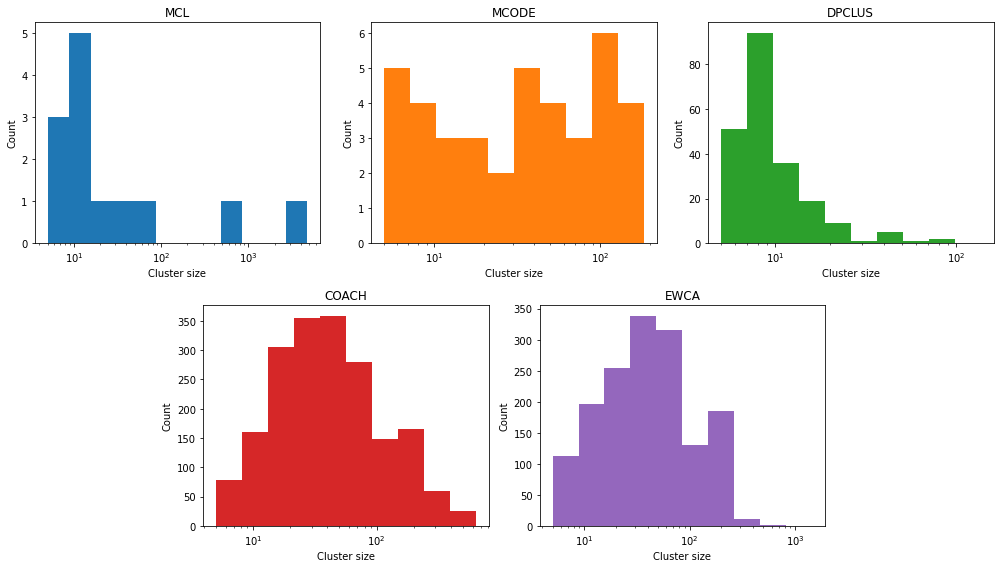

In [47]:
plt.figure(figsize = (14,8))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)



counts, bins = np.histogram(mcl_distr_filter, bins = 12)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax1.hist(mcl_distr_filter, bins=logbins)
ax1.set_title('MCL')
ax1.set_xscale('log')
ax1.set_xlabel('Cluster size')
ax1.set_ylabel('Count')

counts, bins = np.histogram(mcode_distr_filter)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax2.hist(mcode_distr_filter, bins=logbins,facecolor ='#ff7f0e')
ax2.set_title('MCODE')
ax2.set_xscale('log')
ax2.set_xlabel('Cluster size')
ax2.set_ylabel('Count')

counts, bins = np.histogram(dpclus_distr_filter)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax3.hist(dpclus_distr_filter, bins=logbins,facecolor ='#2ca02c')
ax3.set_title('DPCLUS')
ax3.set_xscale('log')
ax3.set_xlabel('Cluster size')
ax3.set_ylabel('Count')

counts, bins = np.histogram(coach_distr_filter)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax4.hist(coach_distr_filter, bins=logbins,facecolor ='#d62728')
ax4.set_title('COACH')
ax4.set_xscale('log')
ax4.set_xlabel('Cluster size')
ax4.set_ylabel('Count')

counts, bins = np.histogram(ewca_distr_filter)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax5.hist(ewca_distr_filter, bins=logbins,facecolor ='#9467bd')
ax5.set_title('EWCA')
ax5.set_xscale('log')
ax5.set_xlabel('Cluster size')
ax5.set_ylabel('Count')

plt.tight_layout()
plt.show()